# Thomas Fire Analysis
#### Author: Anna Ramji ([@a-ramji](https://github.com/a-ramji), a-ramji@github.io)
- This notebook is part of my Thomas Fire analysis [github repository](https://github.com/a-ramji/thomas-fire)
(https://github.com/a-ramji/thomas-fire)


# About

### Purpose


There are two primary goals of this data analysis and visualization. 
1. Use county-level AQI data to show the **air quality in Santa Barbara County from 2017-2018, highlighting the Thomas Fire**, which occurred in December, 2017.
2. Use Landsat and a shapefile of fire perimeters in California to **create a false color image displaying the fire scar from the 2017 Thomas Fire**

### Highlights of analysis
    - Fetch vector data from an online repository
    - Visualize raster data
    - Time series analysis
    - etc
### Dataset description

#### AQI Data
- The AQI data I'll be using in my analysis is [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov) to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County. 
- More specifically, I'll be importing county-level AQI data for 2017 and 2018

#### Landsat Collection 2 Level-2 data from Landsat 8 
- The second is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite
- This data that was accessed and pre-processed in Microsoft's Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)) by Professor Carmen Galaz-García ([@carmengg](https://github.com/carmengg) on GitHub)

#### California Shapefile
- The third dataset is A shapefile of fire perimeters in California during 2017. The [complete file can be accessed in the CA state geoportal.](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about)



### References & data sources

- AQI Data: https://aqs.epa.gov/aqsweb/airdata (Accessed October, 2023)
- Landsat Data: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2, pre-processed on Microsoft's Planetary Computer by Dr. Carmen Galaz-García (Accessed November, 2023). This file will by in a data folder in my github repo for this project. 
- CA Shapefile: as mentioned above, the [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about). I'll be using a local copy of the shapefile in a hidden data folder in this repo. (Accessed November, 2023)

In [1]:
# before we begin our analysis, let's load in the relevant libraries, packages, and modules:

# importing libraries with standard abbreviations
# basic libraries
import os # like here() in R
import numpy as np
import pandas as pd

# for spatial/raster data etc. 
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

# for plotting 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends
import matplotlib.lines as mlines # for making our customized marker in the legend
from matplotlib.lines import Line2D  # also for this custom marker 
from matplotlib.markers import MarkerStyle # also for custom markers


from shapely.geometry import Point 
from shapely.geometry import box # for making our bounding box/cropping (optional)

from rasterio.features import rasterize # for rasterizing polygons

pd.set_option('display.max_columns', None) # setting custom full output options for data exploration (optional) 



# Importing Data

### AQI Data for 2017-2018

In [2]:
# reading in data using the download links in EPA's AQS data (cited in the About section)

# reading in 2017 county-level AQI data  
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')

# reading in 2018 county-level AQI data
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')


### (pre-processed) Landsat Data

In [4]:
# setting file path for landsat data (NetCDF file),
# using os() for multi-operating system compatibility
landsat_fp = os.path.join(os.getcwd(), 'data', 'landsat8-2018-01-26-sb-simplified.nc')

#  importing the landsat data it with rioxarray
landsat = rioxr.open_rasterio(landsat_fp)

### California Fire Borders

In [6]:
# setting file path for CA Fire Perimeters data, 
# using os() for multi-operating system compatibility
ca_fp = os.path.join(os.getcwd(), 'data', 'California_Fire_Perimeters_2017', 'California_Fire_Perimeters_2017.shp')

# importing the CA Fire Perimeters 2017 shapefile from our filepath using geopandas
ca_fires = gpd.read_file(ca_fp)


# Geographical context of data

## AQI Data exploration

In [13]:
# currently, our 2017 and 2018 data are separate. Let's start by concatenating them:

# concatenating our two years of data into one dataframe
aqi = pd.concat([aqi_17, aqi_18])

# viewing the first 3 rows of our concatenated dataset
aqi.head(3)

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1


In [8]:
aqi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654338 entries, 0 to 327536
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   State Name                 654338 non-null  object
 1   county Name                654338 non-null  object
 2   State Code                 654338 non-null  int64 
 3   County Code                654338 non-null  int64 
 4   Date                       654338 non-null  object
 5   AQI                        654338 non-null  int64 
 6   Category                   654338 non-null  object
 7   Defining Parameter         654338 non-null  object
 8   Defining Site              654338 non-null  object
 9   Number of Sites Reporting  654338 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 54.9+ MB


Notes:
- at this stage, the dataset includes AQI data at a county-level for more states than we're interested in for our analysis
- the columns are mostly in Title Case and the datatype of information stored in the `Date` column is currently "object", not a datetime object

## AQI Data Cleaning & Updates


**Let's clean the column names and filter to Santa Barbara County, California.**

In [20]:
# cleaning up the column names to be lower_snake_case
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# let's check to see if the column names were updated properly:
print(aqi.columns)

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')


Nice! Now, we can move on to filter our dataset down to Santa Barbara County

In [21]:
# selecting rows where county_name is equal to "Santa Barbara"
aqi_sb = aqi[aqi.county_name == "Santa Barbara"]

# check to see if the updates were made

# print all unique data points in the county_name column
print(aqi_sb.county_name.unique())

# show the first 3 rows of our updated df
aqi_sb.head(3)

['Santa Barbara']


,state_name,county_name,state_code,county_code,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
28648,California,Santa Barbara,6,83,2017-01-01,39,Good,Ozone,06-083-4003,12
28649,California,Santa Barbara,6,83,2017-01-02,36,Good,Ozone,06-083-4003,11
28650,California,Santa Barbara,6,83,2017-01-03,71,Moderate,PM10,06-083-4003,12


Great! Now that we have our data paired down to Santa Barbara County, we can get rid of the columns before `date`, as they're not providing useful information anymore.

In [22]:
# using .loc to select the columns after county_code
aqi_sb = aqi_sb.loc[:,'date':'number_of_sites_reporting']

# checking if our columns were dropped
print(aqi_sb.columns)

Index(['date', 'aqi', 'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')


Perfect. Now, let's update the datatype of the `date` column to be a datetime object

In [23]:
# using to_datetime from pandas to update date column to be a datetime object
aqi_sb.date = pd.to_datetime(aqi_sb.date)

# checking to see if the data type was properly updated:
print(aqi_sb.dtypes)

date                         datetime64[ns]
aqi                                   int64
category                             object
defining_parameter                   object
defining_site                        object
number_of_sites_reporting             int64
dtype: object


Success! Let's see what our updated dataframe looks like now:

In [24]:
aqi_sb.head(3)

,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
28648,2017-01-01,39,Good,Ozone,06-083-4003,12
28649,2017-01-02,36,Good,Ozone,06-083-4003,11
28650,2017-01-03,71,Moderate,PM10,06-083-4003,12


The `date` column seems like it could be a more useful index than our current index. Setting `date` to be our new index will also help us plot the AQI over time in our analysis later on. 

In [27]:
# updating index to the date column
aqi_sb = aqi_sb.set_index('date')

In [29]:
# checking to see if the index was set properly:
aqi_sb.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=730, freq=None)

Now that our data is cleaned and updated, we can move on to our analysis and visualization.

# AQI Data Analysis

We could just go straight to plotting our AQI data over time in Santa Barbara County, but it would be interesting to also show a 5-day rolling average plotted on top of it. 

In order to make our data visualization more legible, we can compute a [rolling average](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html) of our AQI over time and add that as a column for our analysis.

- `rolling()` is a method for `pandas.series` that provides rolling window calculations
- the parameter `'5D'` indicates we want the window to be 5 days
- This is a lazy method (think groupby), so we need to specify what we want to calculate over each window
- we'll also use the aggregator function `mean()`
    - this indicates that we want the mean over each window

In [30]:
# computing a 5-day rolling average of AQI 
# and inserting it as a new column at the end of the dataframe
aqi_sb.insert(loc = 5,
             column = "five_day_average",
             value = aqi_sb.aqi.rolling('5D').mean())

In [31]:
# checking the new column
aqi_sb.head(3)

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.000000
2017-01-02,36,Good,Ozone,06-083-4003,11,37.500000
2017-01-03,71,Moderate,PM10,06-083-4003,12,48.666667


Great! Now we can make a line plot showing both the daily AQI and the 5-day average (5-day average on top of the AQI), using `matplotlib`

<AxesSubplot:title={'center':'Daily AQI and 5-day average 2017-2018'}, xlabel='Date', ylabel='AQI (PM 2.5)'>

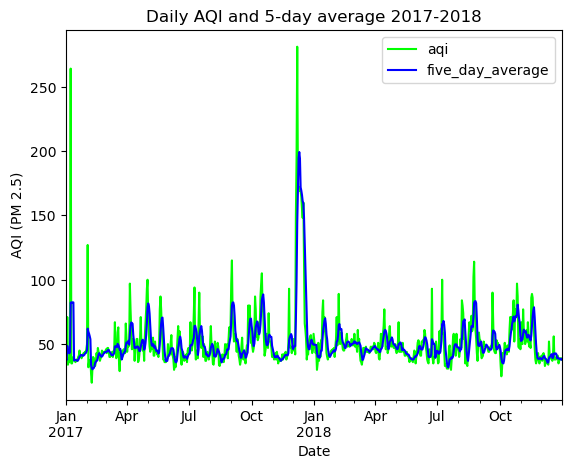

In [35]:
# plotting our daily aqi and five day rolling average aqi on one plot
aqi_sb.plot(y = ['aqi', 'five_day_average'], # selecting two variables for my y-axis to auto-generate a legend
            title = "Daily AQI and 5-day average 2017-2018", # updating title
            xlabel = 'Date', # Updating x-axis label
            ylabel = "AQI (PM 2.5)", # updating y-axis label
            color = {'aqi': 'lime', # customizing colors
                     'five_day_average':'blue'
                    }
           )


Note: we can see a huge spike at December, 2017. This is when the Thomas Fire occurred.


## Landsat raster data exploration

## CA fire border data exploration

In [ ]:
# updating column names: making column names in the California Fire Borders lowercase 
ca_fires.columns = ca_fires.columns.str.lower()

# removing extra/unwanted info: using squeeze() and .drop('band') to remove extra layers from our landsat dataset 
landsat = landsat.squeeze().drop('band')

# reprojecting: ca_fire crs to landsat crs (epsg:32611)
ca_fire_satcrs = ca_fires.to_crs(landsat.rio.crs)


# clipping: clip CA fires to the landsat bounds (optional, helped with processing time)
ca_fires = gpd.clip(ca_fire_satcrs, landsat.rio.bounds())


# filtering: selecting Thomas Fire data by filtering fires data for fire_name == THOMAS
thomas_fire_border = ca_fires.loc[ca_fires.fire_name == "THOMAS"]


# Analysis

In [ ]:


# the AQI spikes in December of 2017, when the Thomas Fire occurred 

# Plotting Thomas Fire Scar

In [ ]:

# initializing plot using matplotlib
fig, ax = plt.subplots(figsize=(9, 7)) # setting figure size for output

# plotting false color image (without creating any new variables)
landsat[['swir22', # short-wave
         'nir08', # near-infrared
         # and red variables
         'red']].to_array().plot.imshow(robust=True, 
                    # using robust=True argument to deal with cloud RGB values squishing our plot
                                                           ax=ax)


# plotting Thomas fire perimeter using the selection of our ca fires subselection 
# filtered for fire_name == THOMAS
thomas_fire_border.plot(color="none", # empty fill color
                   edgecolor="red", # outline color of red for the Thomas Fire
                   # because we're showing perimeter data
                   ax=ax, # sharing same axes
                   )

# updating labels & legend using mpatches.Patch
thomas_fire_border_patch = mpatches.Patch(color='red', # change color to red
                          label='Thomas Fire') # update label

ax.legend(handles = [thomas_fire_border_patch], 
          frameon=False, # removing legend frame
          loc = "upper right", # setting location to upper right-hand side of the plot
          labelcolor = "white") # changing text color so you can see it on the black background


# displaying plot
plt.show()